In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import seaborn as sns
sns.set()


In [ ]:
X = pickle.load(open("../data/interest_rate_data", "rb" ))

In [16]:
X_plot = X[['six_m', 'one_y', 'two_y', 'three_y', 'five_y', 'seven_y', 'ten_y']]


No handles with labels found to put in legend.


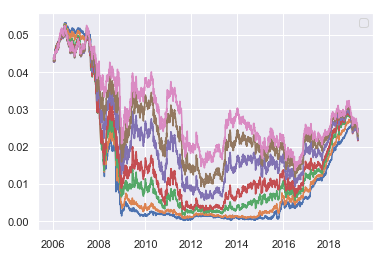

In [33]:
plt.plot(X_plot.index, X_plot)
plt.legend()


In [12]:
def plot_base_rates(X_train):
    fig, axs = plt.subplots( figsize = (12,12))
    fig.suptitle("Historical US Treasury Interest Rates")
    plt.plot(X_train[['six_m', 'one_y', 'two_y', 'three_y', 'five_y', 'seven_y', 'ten_y']])
    plt.legend()
    plt.grid()

No handles with labels found to put in legend.


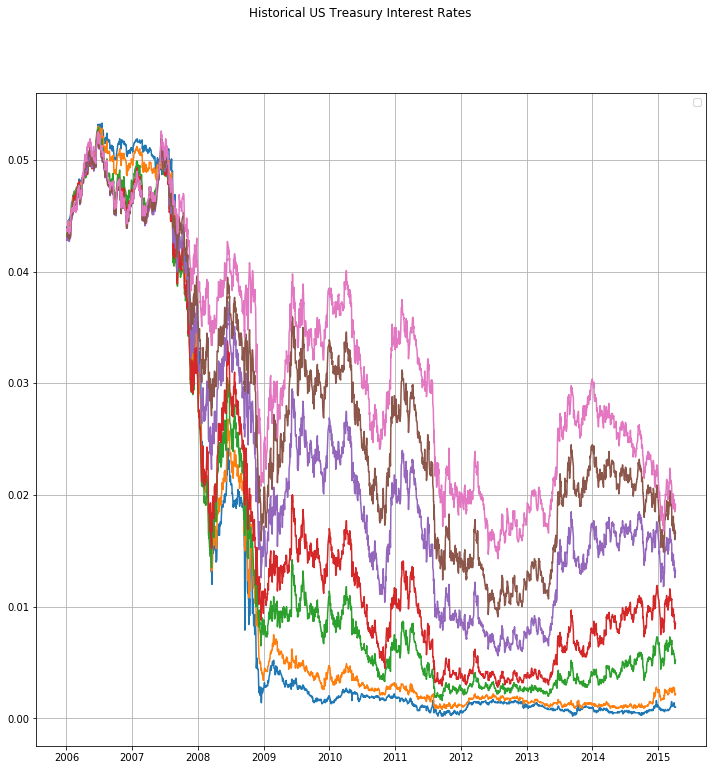

In [13]:
plot_base_rates(X_train)

In [ ]:
def plot_3_pcs(comps, shocks, filename=None):
    ''' TO DO ON THIS PLOT
        1. make the X axis for charts on right the date
        2. optional title with start and end dates
    '''
    fig, axs = plt.subplots(3,2, figsize = (12,12))

    axs[0,0].plot(comps[0, :], color='k')
    axs[0,0].grid()
    axs[0,0].set_facecolor("whitesmoke")
    axs[0,0].set_title("First Principal Component Vector")
    axs[0,1].plot(shocks[:,0], color='r')
    axs[0,1].grid()
    axs[0,1].set_facecolor("whitesmoke")
    axs[0,1].set_title("Shocks due to 1st Component")

    axs[1,0].plot(comps[1, :], color='k')
    axs[1,0].grid()
    axs[1,0].set_facecolor("whitesmoke")
    axs[1,0].set_title("Second Principal Component Vector")
    axs[1,1].plot(shocks[:,1], color='b')
    axs[1,1].grid()
    axs[1,1].set_facecolor("whitesmoke")
    axs[1,1].set_title("Shocks due to 2nd Component")

    axs[2,0].plot(comps[2, :], color='k')
    axs[2,0].grid()
    axs[2,0].set_facecolor("whitesmoke")
    axs[2,0].set_title("Third Principal Component Vector")
    axs[2,1].plot(shocks[:,2], color='g')
    axs[2,1].grid()
    axs[2,1].set_facecolor("whitesmoke")
    axs[2,1].set_title("Shocks due to 3rd Component")

    fig.suptitle("Principal Components of the US Treasury Yield Curve", fontsize = 30, color = 'k')
    fig.show()

    if filename:
        plt.savefig(filename)



In [3]:

X = pickle.load(open("../data/interest_rate_data", "rb" ))
X_fwds = pickle.load(open('../data/forward_rates', 'rb'))
X_zeros = pickle.load(open('../data/zero_rates', 'rb'))



#df_FX = pickle.load( open( "data/FX_data", "rb" ) )

# Loading up the federal reserve metrics and incorporating into our dataframes
fed_metrics = pickle.load( open( "../data/mvp_cosine_sim", "rb" ) )
cos_last = fed_metrics['cos_last']
cos_avg_n = fed_metrics['cos_avg_n']
ed_last = fed_metrics['ed_last']
ed_avg_n = fed_metrics['ed_avg_n']
fed_dates = fed_metrics['dates']

# USING THE PD MERGE BRANDON TAUGHT
avgstats = pd.DataFrame({'date':fed_dates,
                        'ed_last': ed_last,
                        'ed_avg_n': ed_avg_n,
                        'cos_last': cos_last,
                        'cos_avg_n': cos_avg_n}).groupby('date').mean()
avgstats.index = pd.to_datetime(avgstats.index)

X = X.merge(avgstats, how='left', left_index = True, right_index = True)
X_fwds = X_fwds.merge(avgstats, how='left', left_index = True, right_index = True)
X_zeros = X_zeros.merge(avgstats, how = 'left', left_index = True, right_index = True)

X.fillna(value=0, inplace=True)
X_fwds.fillna(value=0, inplace=True)
X_zeros.fillna(value=0, inplace=True)


# Train/Test Split for time series model
total_obs = len(X)
train_int = int(round(total_obs*.7, 0))
cv_int = int(round(total_obs*.85, 0))

fwd_train = X_fwds[0:train_int]
fwd_cv = X_fwds[train_int:cv_int]
fwd_test = X_fwds[cv_int:]

zero_train = X_zeros[0:train_int]
zero_cv = X_zeros[train_int:cv_int]
zero_test = X_zeros[cv_int:]

X_train = X[0:train_int]
X_cv = X[train_int:cv_int]
X_test = X[cv_int:]


In [34]:
whos


Variable          Type         Data/Info
----------------------------------------
X                 DataFrame                three_m   six<...>n[3313 rows x 19 columns]
X_cv              DataFrame                three_m   six<...>\n[497 rows x 19 columns]
X_fwds            DataFrame                 six_m     on<...>n[3313 rows x 18 columns]
X_plot            DataFrame                 six_m   one_<...>\n[3313 rows x 7 columns]
X_test            DataFrame                three_m   six<...>\n[497 rows x 19 columns]
X_train           DataFrame                three_m   six<...>n[2319 rows x 19 columns]
X_zeros           DataFrame                three_m   six<...>n[3313 rows x 19 columns]
avgstats          DataFrame                 ed_last  ed_<...>n\n[521 rows x 4 columns]
cos_avg_n         ndarray      594: 594 elems, type `float64`, 4752 bytes
cos_last          ndarray      594: 594 elems, type `float64`, 4752 bytes
cv_int            int          2816
ed_avg_n          ndarray      594: 59

In [35]:
fwd_train.describe()


,six_m,one_y,two_y,three_y,five_y,seven_y,ten_y,d_six_m,d_one_y,d_two_y,d_three_y,d_five_y,d_seven_y,d_ten_y,ed_last,ed_avg_n,cos_last,cos_avg_n
count,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000
mean,0.013133,0.014555,0.017865,0.023137,0.031716,0.039785,0.043864,-0.000019,-0.000018,-0.000015,-0.000012,-0.000010,-0.000008,-0.000009,0.188767,0.188758,0.036383,0.036380
std,0.019201,0.018206,0.015628,0.014011,0.011659,0.009532,0.008204,0.000442,0.000480,0.000779,0.000825,0.000880,0.000894,0.000770,0.443844,0.443789,0.088877,0.088635
min,0.000200,0.000900,0.002502,0.004105,0.009730,0.017387,0.021694,-0.004900,-0.004344,-0.006169,-0.004756,-0.007153,-0.007652,-0.007034,0.000000,0.000000,0.000000,0.000000
25%,0.001000,0.002001,0.005811,0.012452,0.023363,0.031716,0.036610,-0.000100,-0.000200,-0.000402,-0.000504,-0.000505,-0.000516,-0.000446,0.000000,0.000000,0.000000,0.000000
50%,0.001800,0.004105,0.011242,0.019731,0.030936,0.042476,0.046185,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000022,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.019700,0.023235,0.026478,0.030916,0.041222,0.047485,0.050698,0.000100,0.000200,0.000401,0.000409,0.000485,0.000476,0.000420,0.000000,0.000000,0.000000,0.000000
max,0.053300,0.053600,0.053497,0.053087,0.053215,0.055391,0.061604,0.007500,0.003650,0.005763,0.003650,0.004026,0.011311,0.003459,1.347747,1.347747,0.405139,0.405139
